In [0]:
%pip install yfinance

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-a1501dcd-eb19-427e-8339-c3d84c620b08/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-a1501dcd-eb19-427e-8339-c3d84c620b08/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpmb43xri4
       cwd: /tmp/pip-install-0qmyqn44/peewee_3d38aede38eb4f33a4ad4d35fef0d920
  Complete output (40 lines):
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  
  
  # We define an xConnect function, but leave xCreate NULL so that the
  # table-function can be called eponymously.
  cdef int pwConnect(sqlite3 *db, void *pAux, int argc, cons

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("IsolationForestConstruction") \
    .getOrCreate()

In [0]:
import math
import random
import time

import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from pyspark.sql.functions import col, corr

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pyspark.ml.feature import VectorAssembler

In [0]:
# ***************************************************************************************************************************************
# Step 1: Stock data collection from yfinance
def collect_stock_data(stock='SBUX'):
    """
    Collects historical stock data using yfinance.
    """
    print("Collecting stock data for: ", stock)
    stockTicker = yf.Ticker(stock)
    stock_data = stockTicker.history(period="max")
    stock_data_df = spark.createDataFrame(stock_data)
    return stock_data, stock_data_df

# ***************************************************************************************************************************************
# Step 2: Preprocessing data and Feature selection
def preprocess_data(dataset_df, compute_correlation=False):
    """
    Preprocesses the stock data and extracting relevant features.
    """
    print("Preprocessing data...")
    # Drop NaN values
    dataset_df = dataset_df.dropna()
    dataset_pd = dataset_df.toPandas()
    if compute_correlation:
        # Assuming dataset_pd is your Pandas DataFrame
        dataset_correlation = dataset_pd.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(dataset_correlation, annot=True, cmap='coolwarm', fmt=".3f")
        plt.title('Daraset Correlation Heatmap')
        plt.show()

    # Open, Close, High and Low are highly correlated, so choosing Open price
    selected_features = dataset_df.select('Open')
    return selected_features

# ***************************************************************************************************************************************
# Step 3: Construct Isolation forest (group of trees)
class ExternalNode:
    def __init__(self, data_points):
        # Store the data points in this leaf node
        self.data_points = data_points
        self.avg_path_length = float('inf')

class InternalNode:
    def __init__(self, split_attribute, split_value, left_node, right_node):
        self.split_attribute = split_attribute  # Attribute used for splitting
        self.split_value = split_value  # Value used for splitting
        self.left_node = left_node  # Left subtree
        self.right_node = right_node  # Right subtree

def get_random_attribute_index(dataset):
    """Selects a random attribute index from the given dataset X."""
    return np.random.randint(dataset.shape[1])

def get_random_value(max_value, min_value):
    """Selects a random value within the range defined by max_value and min_value."""
    return random.uniform(min_value, max_value)

def construct_forest(dataset, trees_count, subsample_count):
    """
    Construct trees_count with given subsample_count data points.
    Returns a list of root nodes of trees in the forest.
    """
    print("Constructing Isolation forest...")
    tree_indices = spark.sparkContext.parallelize(range(trees_count))
    forest = tree_indices.map(lambda i: construct_tree_using_subsamples(dataset, subsample_count)).collect()
    
    print("Isolation Forest constructed!")
    return forest

def construct_tree_using_subsamples(dataset, subsample_count):
    """
    Samples a set of datapoints from dataset
    """
    # Randomly sample the dataset
    indices = np.random.choice(dataset.shape[0], subsample_count, replace=False)
    dataset_sample = dataset[indices]
    max_tree_height = math.ceil(math.log2(subsample_count))
    return construct_tree(dataset_sample, 0, max_tree_height)

def construct_tree(data, current_height, max_tree_height):
    """
    Recurisvely constructs a tree from sampled data.
    """
    print("Constructing tree...")
    if len(data) == 0:
        return None
    if len(data) == 1:
        return ExternalNode(data)
    
    if current_height >= max_tree_height:
        # Create an external node if maximum height is reached
        return ExternalNode(data)
     
    # Select a random attribute index
    attribute_index = get_random_attribute_index(data)

    # Select a random split value for the chosen attribute
    split_value = get_random_value(data[:, attribute_index].max(), data[:, attribute_index].min())

    # Split the data into left and right subsets based on the split value
    data_left = data[data[:, attribute_index] < split_value]
    data_right = data[data[:, attribute_index] >= split_value]

    # Recursively construct the left and right subtrees
    left_subtree = construct_tree(data_left, current_height + 1, max_tree_height)
    right_subtree = construct_tree(data_right, current_height + 1, max_tree_height)

    # Create an internal node for the split
    return InternalNode(attribute_index, split_value, left_subtree, right_subtree)

# ***************************************************************************************************************************************
# Step 4: Compute path length for a datapoint in a tree (test instance)
def is_external_node(node):
    """Checks if the node is an external (leaf) node."""
    return isinstance(node, ExternalNode)

def c(node_size):
    """Computes the standardized value to add to path length for a node."""
    return 2 * (math.log(node_size - 1) + 0.5772156649) - (2 * (node_size - 1) / node_size)

def get_path_length(data_point, tree_node, edge_count):
    """
    Returns the path length of data_point in the tree
    edge_count
    """
    if data_point is None or tree_node is None:
        return edge_count
    
    # tree_node is the external node in subtree,
    # compute the path length and return.
    if is_external_node(tree_node):
        if len(tree_node.data_points) == 1:
            return edge_count
        return edge_count + c(len(tree_node.data_points))
    
    # tree_node is the internal node
    if data_point[tree_node.split_attribute] < tree_node.split_value:
        # Traverse left subtree
        return get_path_length(data_point, tree_node.left_node, edge_count + 1)
    else:
        # Traverse right subtree
        return get_path_length(data_point, tree_node.right_node, edge_count + 1)

def compute_anomaly_score(dataset, forest):
    avg_path_length_list = []
    if forest is None:
        return None
    for data_point in dataset:
        avg_path_length = sum(get_path_length(data_point, tree, 0) for tree in forest) / len(forest)
        avg_path_length_list.append(avg_path_length)
    anomaly_scores = [pow(2, -avg_path_length) for avg_path_length in avg_path_length_list]
    return anomaly_scores

def normalize_anomaly_scores(anomaly_scores):
    if anomaly_scores is None:
        return None
    min_score = min(anomaly_scores)
    max_score = max(anomaly_scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in anomaly_scores]
    return normalized_scores

def compute_anomaly_label(anomaly_scores):
    if anomaly_scores is None:
        return None
    # Using a threshold of 0.5 to compare with sklearn's isolation forest.
    anomaly_labels = [-1 if score >= 0.5 else 1 for score in anomaly_scores]
    return anomaly_labels


# ***************************************************************************************************************************************
# Step 5: Train isolation forest model
def train_isolation_forest(train_data, trees_count = 100, num_samples = 256):
    """
    Constructs an isolation forest using train_data
    Calculates anomaly scores for train_data
    Returns Isolation forest and Anomaly scores using train_data
    """
    isolation_forest = construct_forest(train_data, trees_count, num_samples)

    # Calculate the anomaly_score for each instance
    # Anomaly has anomaly_score closer to 1
    anomaly_scores = compute_anomaly_score(train_data, isolation_forest)
    normalized_scores = normalize_anomaly_scores(anomaly_scores)

    return isolation_forest, normalized_scores

# ***************************************************************************************************************************************
# Step 6: Compare results with isolation forest library results
def compare_results(predicted_anomalies, isolation_forest_anomalies):
    # Calculate the total number of samples
    total_samples = len(predicted_anomalies)

    # Initialize counts for correct and incorrect anomaly scores
    correct_count = sum(1 for predicted, iso_forest in zip(predicted_anomalies, isolation_forest_anomalies) if predicted == iso_forest)
    incorrect_count = total_samples - correct_count

    # Calculate percentages
    correct_percentage = (correct_count / total_samples) * 100
    incorrect_percentage = (incorrect_count / total_samples) * 100

    print("Count of correct anomaly scores:", correct_count)
    print("Count of incorrect anomaly scores:", incorrect_count)

    print("Percentage of correct anomaly scores:", correct_percentage)
    print("Percentage of incorrect anomaly scores:", incorrect_percentage)

# ***************************************************************************************************************************************
# Step 7: Compare results with isolation forest library results
def visualize_data(data_df):
    # Convert the RDD to a list of open prices
    open_prices = data_df['Open']
    plt.figure(figsize=(12, 6))
    plt.plot(open_prices, color='blue')
    plt.title('Starbucks (SBUX) Stock Price (Train data)')
    plt.xlabel('Index')
    plt.ylabel('Open Price (USD)')
    plt.grid(True)
    plt.show()

def visualize_data_and_anomalies(data, anomalies, title='Anomalies in Starbucks (SBUX) Stock Price'): 
    # Plotting the data points on the plot
    plt.figure(figsize=(12, 6))
    plt.plot(data['Open'], color='blue', label='Open Price')
    plt.xlabel('Date')
    plt.ylabel('Open Price (USD)')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Adding anomaly points with color red on the first plot
    anomaly_indices = np.where(anomalies == -1)[0]
    data_anomalies = data.iloc[anomaly_indices]
    plt.scatter(data_anomalies.index, data_anomalies['Open'], color='red', label='Anomaly')

def visualize_test_data(train_data, test_data):
    print('Visualizing train and test data...')
    plt.figure(figsize=(12, 6))
    # Define colors based on anomaly labels
    colors = np.where(test_data['anomaly_score'] == -1, 'red', 'green')

    # Plotting the 'Open' price of train data
    plt.plot(train_data['Open'], color='blue', label='Train Data')

    # Plotting additional data (e.g., 'Open' price of test data)
    plt.scatter(test_data.index, test_data['Open'], color=colors, label='Test Data', marker='X')

    # Adding title, labels, legend, and grid
    plt.title('Starbucks (SBUX) Stock Price (with anomalies)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    
    # Show plot
    plt.show()


              Open         High          Low        Close        Volume  \
count  8024.000000  8024.000000  8024.000000  8024.000000  8.024000e+03   
mean     26.798668    27.060997    26.529836    26.801346  1.470642e+07   
std      31.935204    32.214362    31.644972    31.933592  1.340840e+07   
min       0.256572     0.271844     0.250463     0.262681  1.504000e+06   
25%       3.432566     3.536845     3.361704     3.439288  7.814475e+06   
50%      10.403333    10.531130    10.270695    10.411389  1.170245e+07   
75%      47.822618    48.127689    47.402073    47.763267  1.778795e+07   
max     118.924630   119.150997   117.726701   118.905746  5.855088e+08   

         Dividends  Stock Splits  
count  8024.000000   8024.000000  
mean      0.001926      0.001496  
std       0.026843      0.054673  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       0.570000      2.000000  


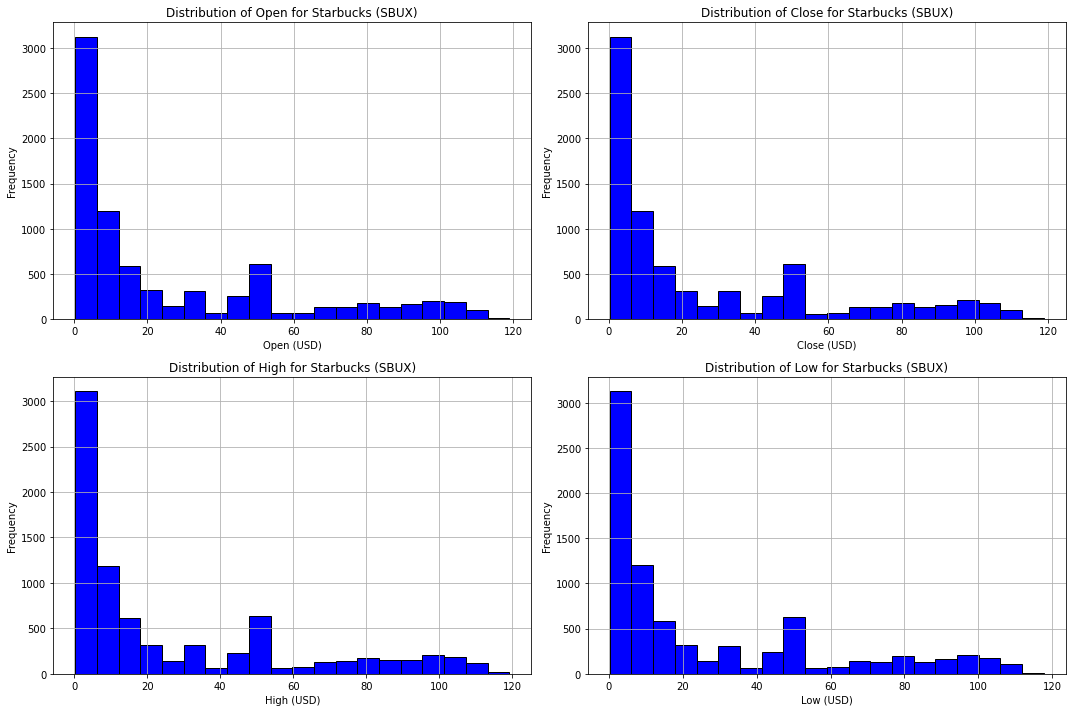

In [0]:
# 1. Collect and Analyze the data
dataset_pd, dataset_df = collect_stock_data('SBUX')

print(dataset_pd.describe())

# Avoiding Dividends and Stock Splits
feature_names = ['Open', 'Close', 'High', 'Low']

# Create a figure and axes for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, feature in enumerate(feature_names):
    ax = axes[i]
    ax.hist(dataset_pd[feature], bins=20, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of {feature} for Starbucks (SBUX)')
    ax.set_xlabel(f'{feature} (USD)')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

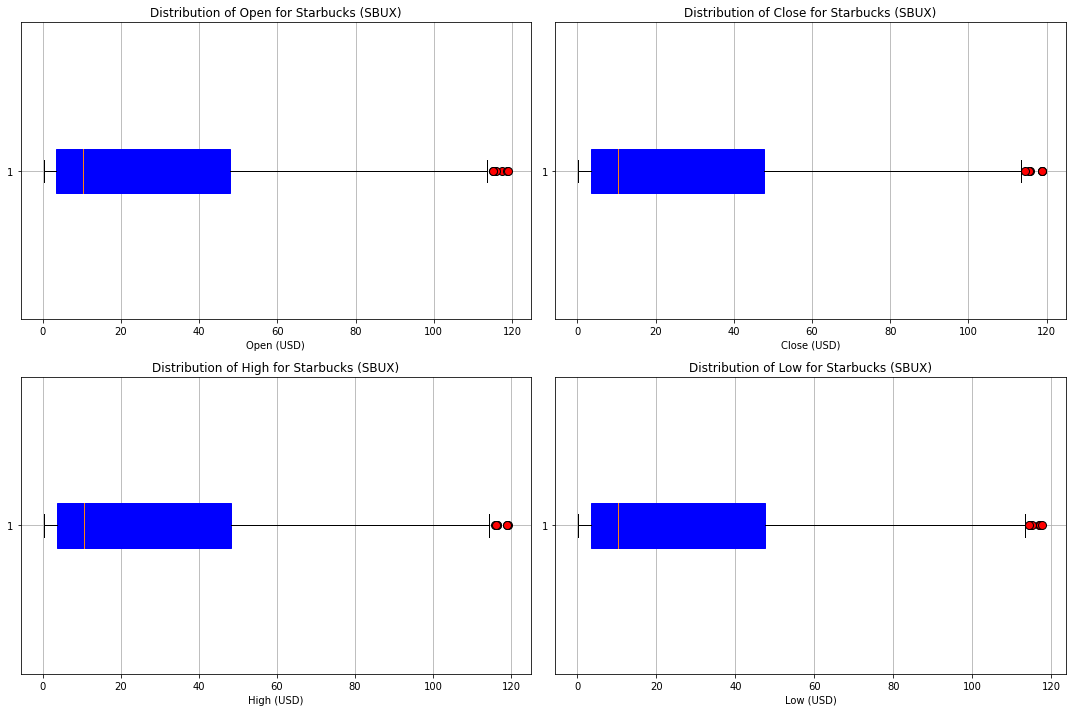

In [0]:
# Create a figure and axes for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes array to easily access each subplot
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(feature_names):
    ax = axes[i]
    ax.boxplot(dataset_pd[feature], vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='blue'), flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
    ax.set_title(f'Distribution of {feature} for Starbucks (SBUX)')
    ax.set_xlabel(f'{feature} (USD)')
    ax.grid(True)

plt.tight_layout()
plt.show()

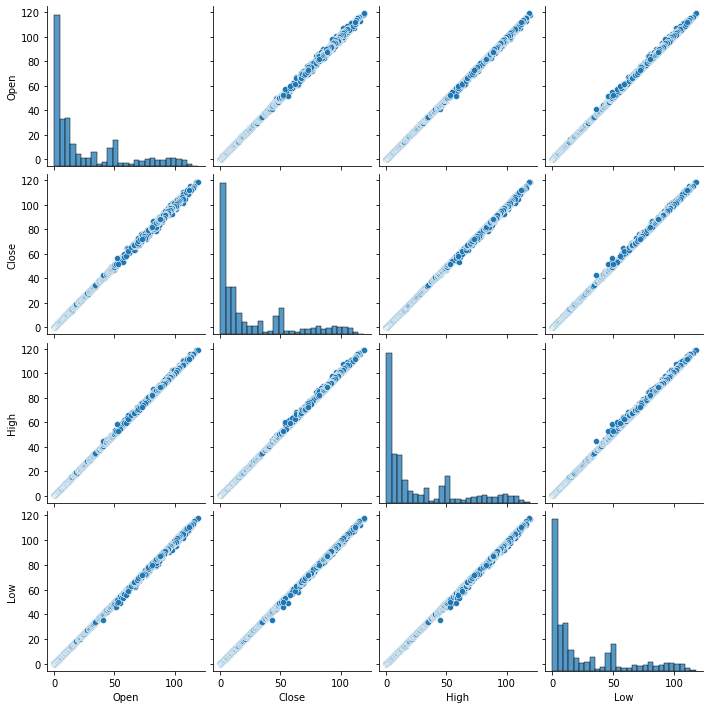

In [0]:
# Create pair plot
sns.pairplot(dataset_pd[feature_names], palette='dark')

# Show the plot
plt.show()

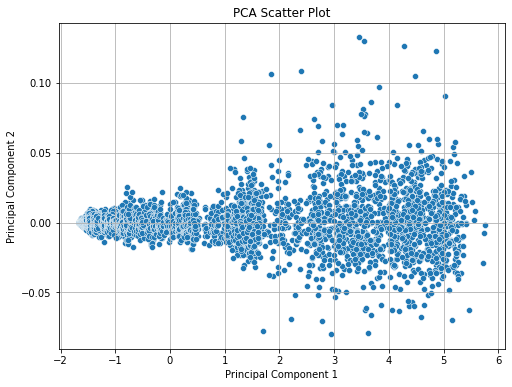

In [0]:
# Looking for outliers in the data by visual means
scaler_model = StandardScaler()
scaled_data = scaler_model.fit_transform(dataset_pd[feature_names])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Preprocessing data...


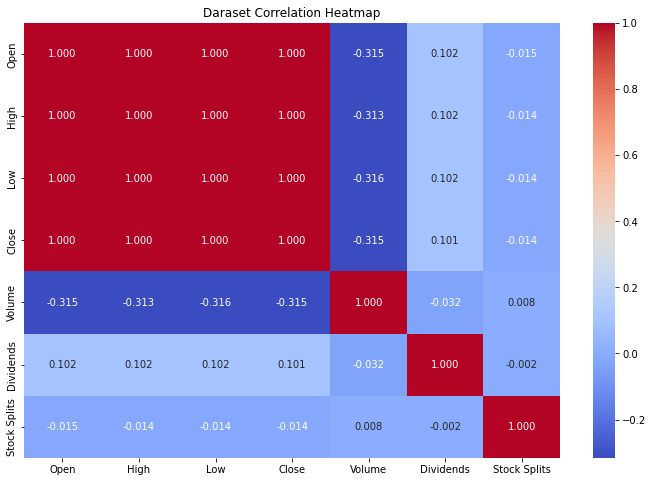

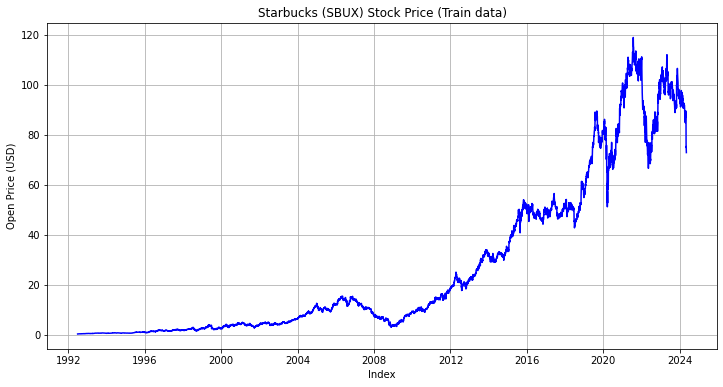

In [0]:
# 2. Preprocess and Visualize the data
preprocessed_df = preprocess_data(dataset_df, compute_correlation=True)
preprocessed_df_cache = preprocessed_df.cache()
visualize_data(dataset_pd)

In [0]:
# 3. Train isolation forest on train data 
dataset_broadcast = spark.sparkContext.broadcast(preprocessed_df_cache.collect())
dataset_val = np.array(dataset_broadcast.value)
trees_count = 100
subsample_count = 512

isolation_forest, anomaly_scores = train_isolation_forest(dataset_val, trees_count, subsample_count)

# Computing anomaly labels to compare with sklearn's isolation forest 
predicted_anomaly_label = compute_anomaly_label(anomaly_scores)

Constructing Isolation forest...
Isolation Forest constructed!


In [0]:
# 4. Using sklearn's Isolation Forest model with the data
model = IsolationForest(contamination=0.01)
model.fit(dataset_val)
isolation_forest_anomalies = model.predict(dataset_val)

Count of correct anomaly scores: 7969
Count of incorrect anomaly scores: 55
Percentage of correct anomaly scores: 99.31455633100697
Percentage of incorrect anomaly scores: 0.685443668993021


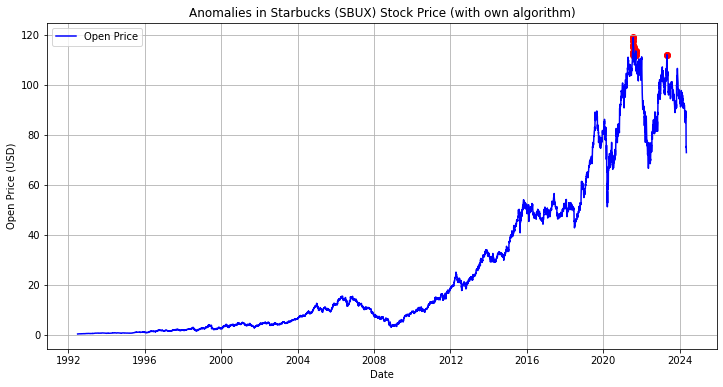

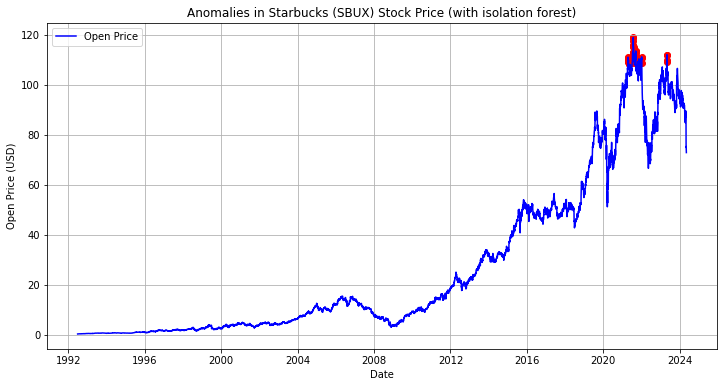

In [0]:
# 5. Comparing implemented algorithn and sklearn's algorithm
compare_results(predicted_anomaly_label, isolation_forest_anomalies)
visualize_data_and_anomalies(dataset_pd, np.array(predicted_anomaly_label), title='Anomalies in Starbucks (SBUX) Stock Price (with own algorithm)')
visualize_data_and_anomalies(dataset_pd, isolation_forest_anomalies, title='Anomalies in Starbucks (SBUX) Stock Price (with isolation forest)')

In [0]:
# 6. Test trained isolation forest using the streaming data from yfinance ticker

# Testing for anomalies in streaming data
# Interrupt the execution to visualize the results
def test_anomaly_real_time(isolation_forest, stock='SBUX', period = '1d', interval = '60m', one=False):
    """
    isolation_forest: trained isolation forest
    stock: Stock Ticker(same as train)
    period: time span of data to download
    interval: time between each data 
    one: if True: tests only the tail datapoint, else uses entire data
    """

    # Create a loop to fetch real-time data at intervals
    test_data_gathered = []
    while True:
        try:
            # Fetch real-time data for the specified ticker
            ticker = yf.Ticker(stock)
            data = ticker.history(period=period, interval=interval)

            # Preprocess test data
            downloaded_test_data = data.tail(1) if one else data
            test_data_df = spark.createDataFrame(downloaded_test_data)
            preprocessed_test_data = preprocess_data(test_data_df)

            test_data = np.array(preprocessed_test_data.rdd.collect())
            predicted_test_anomaly_scores = compute_anomaly_score(test_data, isolation_forest)
            
            # Calculate the anomaly_label for each instance
            predicted_test_anomaly_labels = compute_anomaly_label(predicted_test_anomaly_scores)

            for i in range(test_data.shape[0]):
                print("Test data point: {}, Anomaly Score: {}, Anomaly Label: {}".format(test_data[i], predicted_test_anomaly_scores[i], predicted_test_anomaly_labels[i]))

            downloaded_test_data['anomaly_score'] = predicted_test_anomaly_labels
            test_data_gathered.append(downloaded_test_data)
            # Sleep for a specified interval before fetching data again
            print("Sleeping for 60 seconds...")
            time.sleep(60)  # Sleep for 60 seconds (1 minute)       
        except KeyboardInterrupt:
            print("Streaming stopped by user.")
            return test_data_gathered
        except Exception as e:
            print("An error occurred:", e)

tested_data = test_anomaly_real_time(isolation_forest, 'SBUX', period = '1d', interval = '60m', one=False)

Preprocessing data...
Test data point: [72.84999847], Anomaly Score: 0.001430311166545911, Anomaly Label: 1
Test data point: [72.25], Anomaly Score: 0.0013304733503970265, Anomaly Label: 1
Test data point: [72.59799957], Anomaly Score: 0.0014104825588353211, Anomaly Label: 1
Test data point: [72.15499878], Anomaly Score: 0.0013047282107462883, Anomaly Label: 1
Test data point: [72.06999969], Anomaly Score: 0.001306605151034193, Anomaly Label: 1
Test data point: [72.125], Anomaly Score: 0.0013047282107462883, Anomaly Label: 1
Test data point: [72.30509949], Anomaly Score: 0.0013901538949650375, Anomaly Label: 1
Sleeping for 60 seconds...


                                Open       High        Low      Close  \
Datetime                                                                
2024-05-07 09:30:00-04:00  72.849998  72.849998  72.129997  72.250000   
2024-05-07 10:30:00-04:00  72.250000  72.695000  72.229897  72.595001   
2024-05-07 11:30:00-04:00  72.598000  72.620003  72.120003  72.158699   
2024-05-07 12:30:00-04:00  72.154999  72.160004  71.930000  72.070000   
2024-05-07 13:30:00-04:00  72.070000  72.139999  71.800003  72.121696   
2024-05-07 14:30:00-04:00  72.125000  72.360001  71.989998  72.300003   
2024-05-07 15:30:00-04:00  72.305099  72.540001  72.190002  72.500000   

                            Volume  Dividends  Stock Splits  anomaly_score  
Datetime                                                                    
2024-05-07 09:30:00-04:00  4908248        0.0           0.0              1  
2024-05-07 10:30:00-04:00  2313729        0.0           0.0              1  
2024-05-07 11:30:00-04:00  2322304

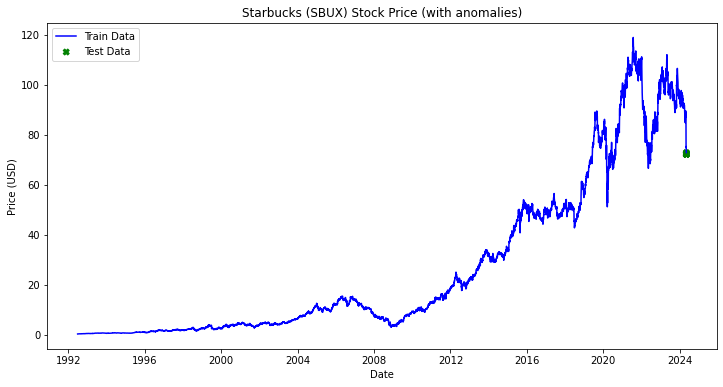

In [0]:
# 7. Visualize train and test data
tested_data_df = pd.concat(tested_data)
print(tested_data_df)
visualize_test_data(dataset_pd, tested_data_df)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import Estimator, Transformer
from pyspark.sql import Row

# Anomaly detection process as a Transformer
class AnomalyDetectorTransformer(Transformer):
    def __init__(self, forest=None):
        super(AnomalyDetectorTransformer, self).__init__()
        self.forest = forest

    def _transform(self, df):
        # Calculate the anomaly_label for each instance (path length)
        print("Transforming....")
        anomaly_scores = compute_anomaly_score(df, self.forest)

        normalized_scores = normalize_anomaly_scores(anomaly_scores)

        algo_anomaly_label = compute_anomaly_label(normalized_scores)
        
        return algo_anomaly_label

# Forest creation process as an Estimator
class AnomalyDetectorEstimator(Estimator):
    def __init__(self, trees_count=200, subsample_count=512):
        super(AnomalyDetectorEstimator, self).__init__()
        self.trees_count = trees_count
        self.subsample_count = subsample_count

    def _fit(self, df):
        print("Fitting...")
        self.forest  = construct_forest(df, self.trees_count, self.subsample_count) 
        return AnomalyDetectorTransformer(self.forest)


In [0]:
from pyspark.sql.functions import monotonically_increasing_id

# Convert isolation_forest_anomalies to a list of integers
anomaly_labels = isolation_forest_anomalies.tolist()

# Convert the list of anomaly labels to a RDD of Rows
anomaly_rows = spark.sparkContext.parallelize(anomaly_labels).map(lambda x: Row(anomaly_label=x))

# Create a DataFrame from the RDD of Rows
anomaly_df = spark.createDataFrame(anomaly_rows)

# Add a unique index to join the data
anomaly_df = anomaly_df.withColumn("index", monotonically_increasing_id())

# Add the anomaly labels to the dataset_df by joining on the index
dataset_df = dataset_df.withColumn("index", monotonically_increasing_id())
dataset_df = dataset_df.join(anomaly_df, on="index", how="left").drop("index")

# Show the updated DataFrame
dataset_df.show()

+-------------------+-------------------+-------------------+-------------------+---------+---------+------------+-------------+
|               Open|               High|                Low|              Close|   Volume|Dividends|Stock Splits|anomaly_label|
+-------------------+-------------------+-------------------+-------------------+---------+---------+------------+-------------+
| 0.3390417725408798|0.35125948735577517|0.33598755356813076| 0.3482052683830261|  7052800|      0.0|         0.0|            1|
|0.25657190534925317| 0.2718438561449667|   0.25046344661833|0.26268115639686584|224358400|      0.0|         0.0|            1|
| 0.2779530477604126| 0.2779530477604126|0.26878958019013494|  0.271843820810318| 15500800|      0.0|         0.0|            1|
| 0.2779531180858612| 0.2779531180858612|0.27184388959005906| 0.2779531180858612| 10662400|      0.0|         0.0|            1|
|  0.281007251272551|0.28711650071932565| 0.2748987941422582| 0.2840614914894104| 11040000|      

In [0]:
anomaly_detector_estimator = AnomalyDetectorEstimator(trees_count, subsample_count)  

# Stages for the pipeline
pipeline_stages = [anomaly_detector_estimator]

anomaly_detection_pipeline = Pipeline(stages=pipeline_stages)

train_data_with_labels, test_data_with_labels = dataset_df.randomSplit([0.8, 0.2], seed=42)

train_data = train_data_with_labels.select(['Open'])
test_data = test_data_with_labels.select(['Open'])

In [0]:
# Fit the pipeline to training data
fitted_pipeline = anomaly_detection_pipeline.fit(np.array(train_data.rdd.collect()))

Fitting...
Constructing Isolation forest...
Isolation Forest constructed!


In [0]:
train_data_anomaly_labels = fitted_pipeline.transform(np.array(train_data.collect()))
compare_results(np.array(train_data_anomaly_labels), np.array(train_data_with_labels.select(['anomaly_label']).rdd.collect()))

Transforming....
Count of correct anomaly scores: 6399
Count of incorrect anomaly scores: 48
Percentage of correct anomaly scores: 99.25546765937645
Percentage of incorrect anomaly scores: 0.7445323406235459


In [0]:
test_data_anomaly_labels = fitted_pipeline.transform(np.array(test_data.rdd.collect()))
compare_results(np.array(test_data_anomaly_labels), np.array(test_data_with_labels.select(['anomaly_label']).rdd.collect()))

Transforming....
Count of correct anomaly scores: 1555
Count of incorrect anomaly scores: 22
Percentage of correct anomaly scores: 98.60494610019023
Percentage of incorrect anomaly scores: 1.3950538998097652


Preprocessing data...


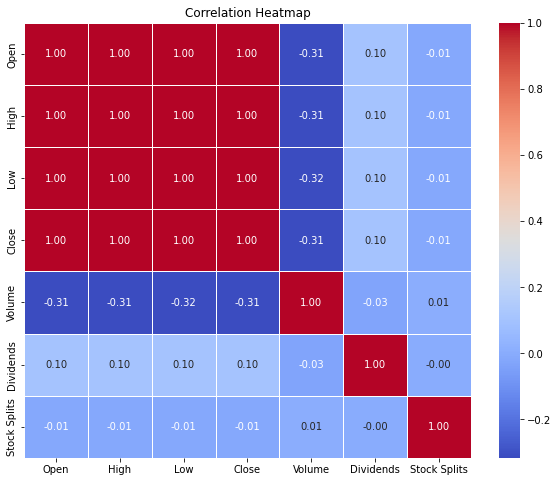

Trees Count: 50, Subsample Count: 256
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 8016
Count of incorrect anomaly scores: 7
Percentage of correct anomaly scores: 99.91275084133117
Percentage of incorrect anomaly scores: 0.08724915866882711
Trees Count: 50, Subsample Count: 512
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 7957
Count of incorrect anomaly scores: 66
Percentage of correct anomaly scores: 99.1773650754082
Percentage of incorrect anomaly scores: 0.8226349245917987
Trees Count: 50, Subsample Count: 1024
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 7949
Count of incorrect anomaly scores: 74
Percentage of correct anomaly scores: 99.07765175121526
Percentage of incorrect anomaly scores: 0.922348248784744
Trees Count: 100, Subsample Count: 256
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomal

<command-858231070792345>:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))


Isolation Forest constructed!
Count of correct anomaly scores: 7947
Count of incorrect anomaly scores: 76
Percentage of correct anomaly scores: 99.05272342016703
Percentage of incorrect anomaly scores: 0.9472765798329803


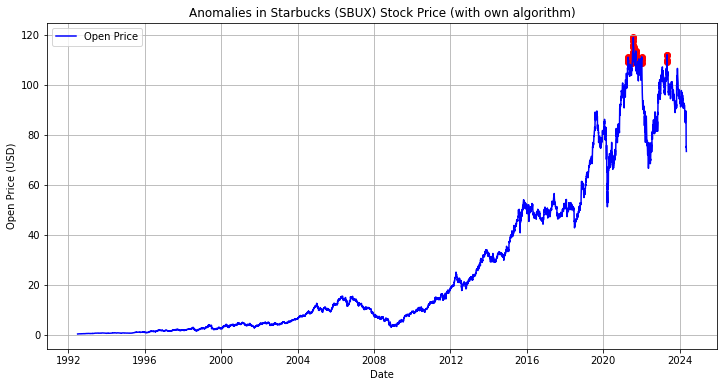

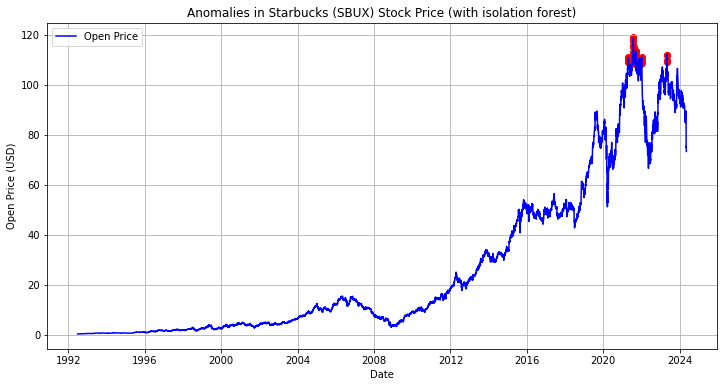

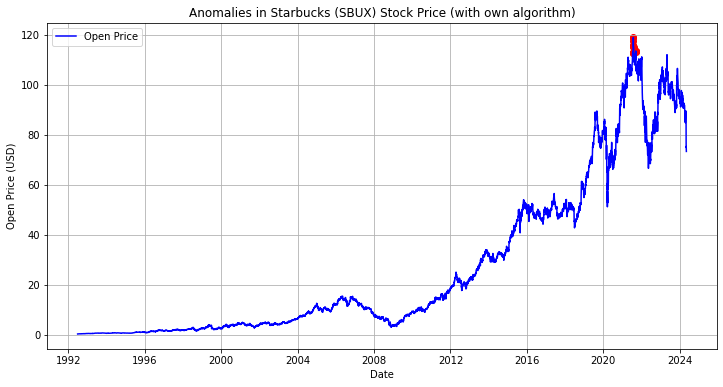

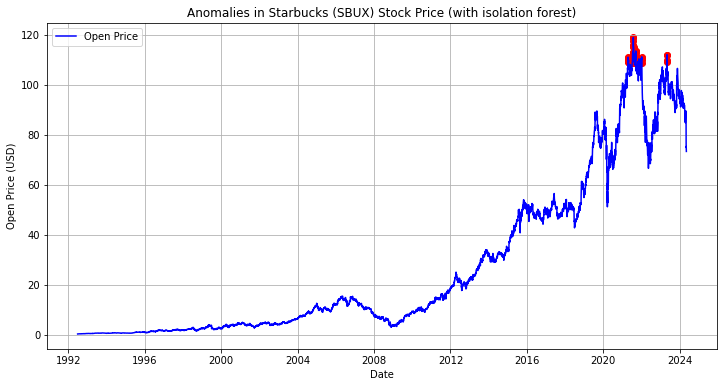

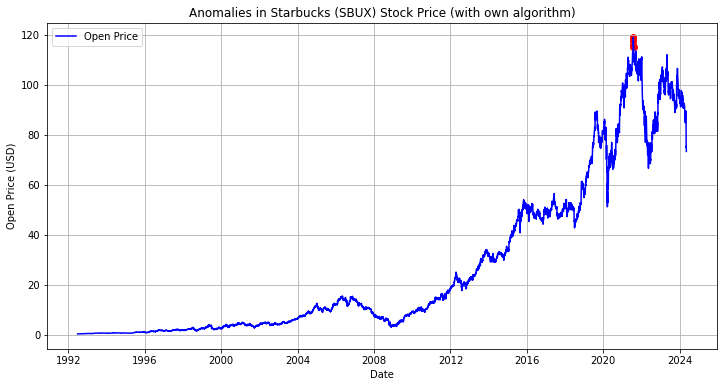

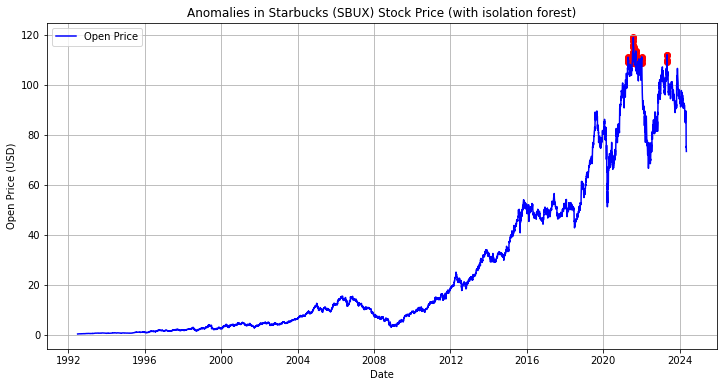

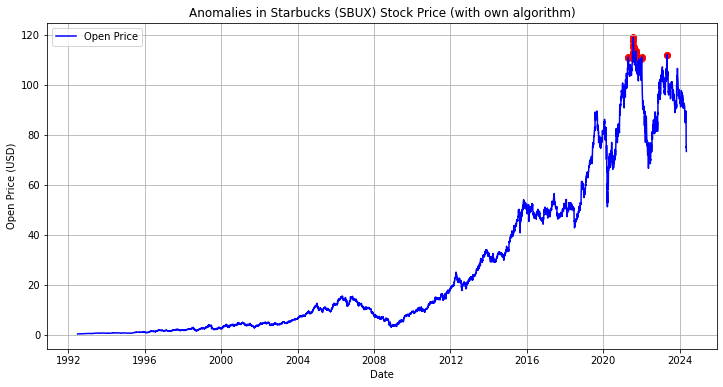

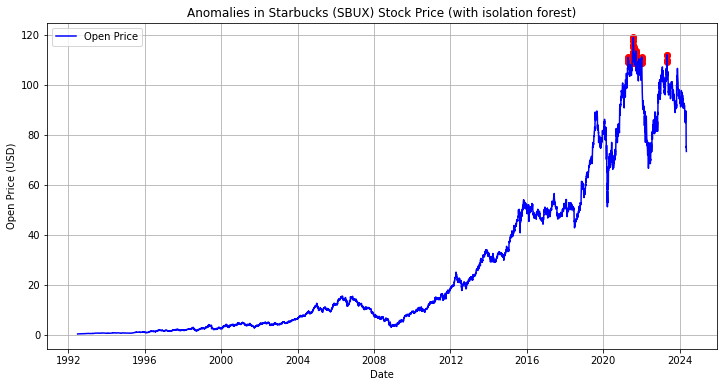

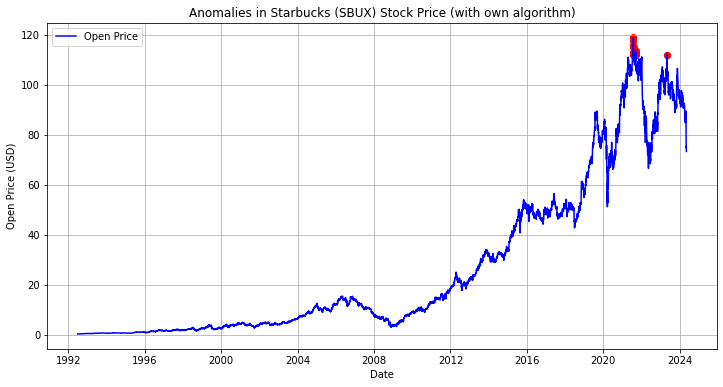

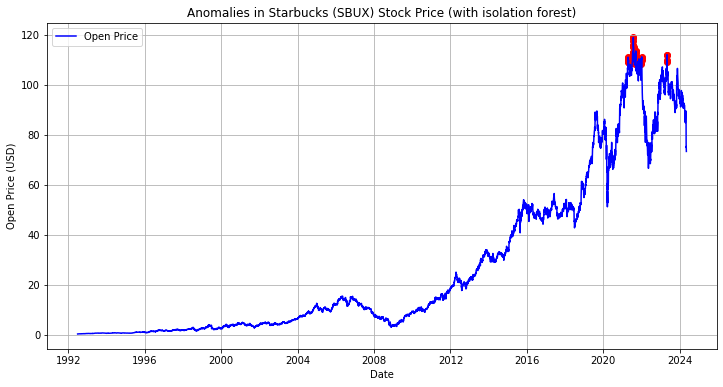

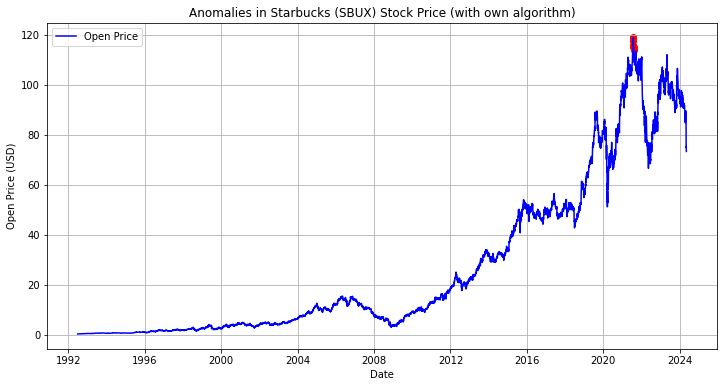

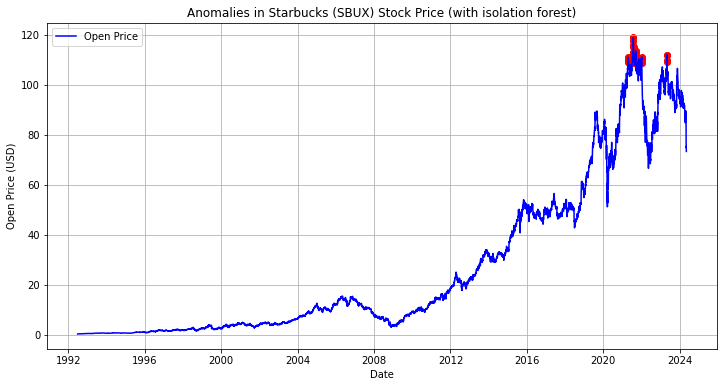

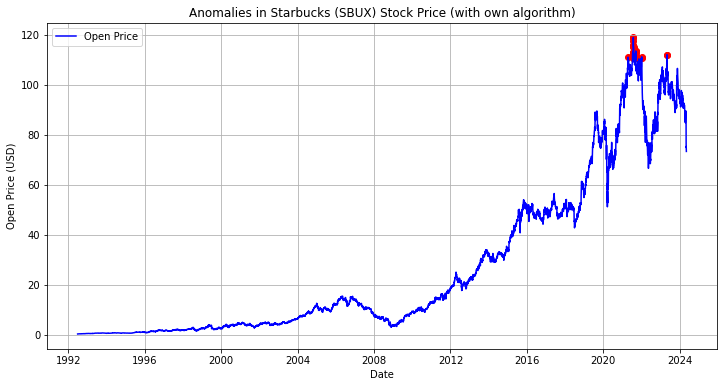

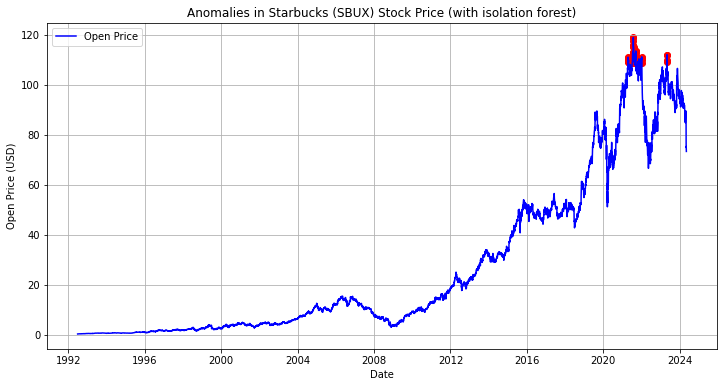

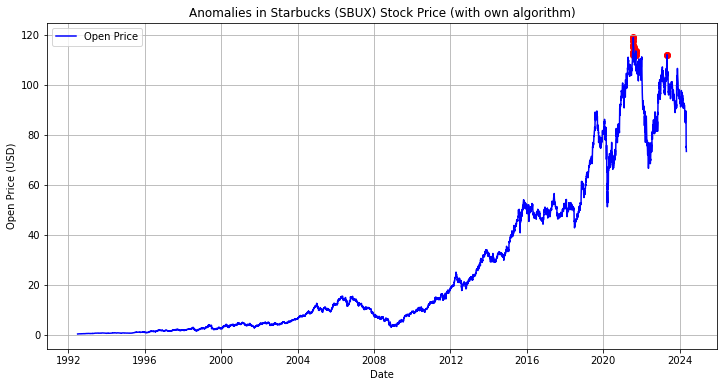

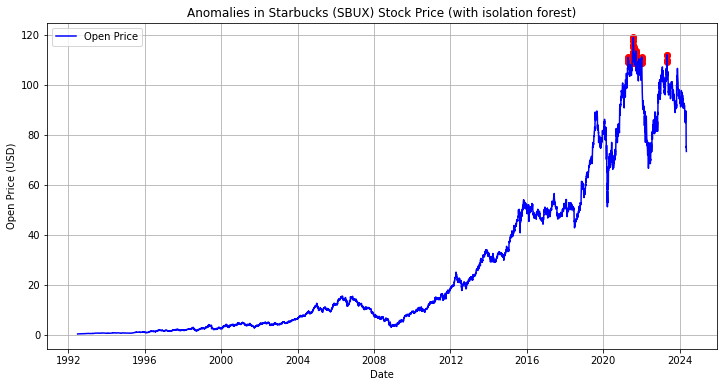

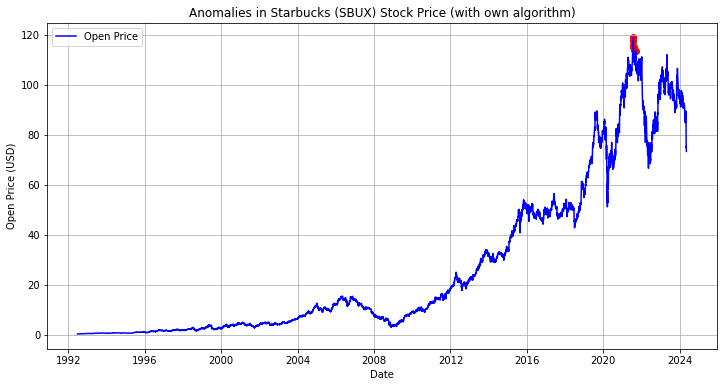

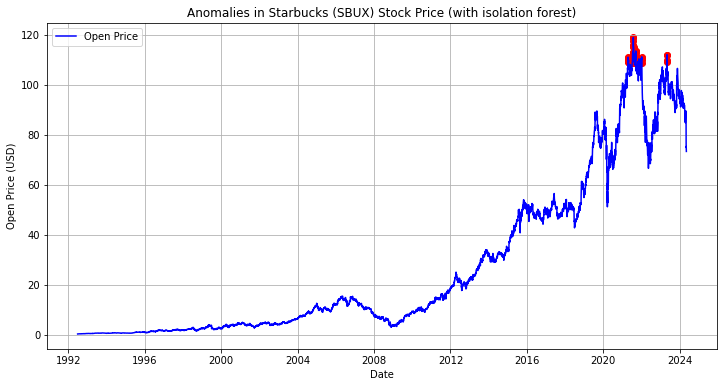

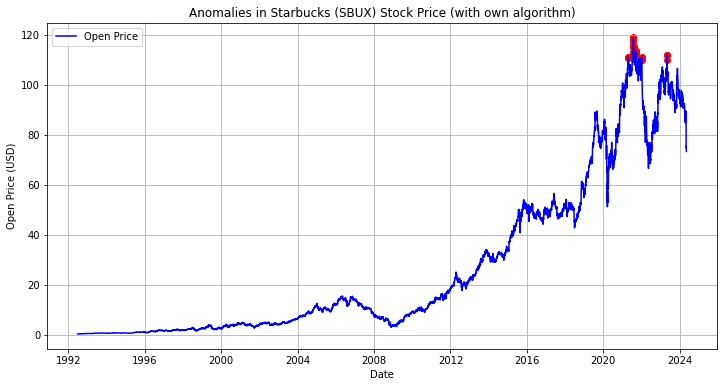

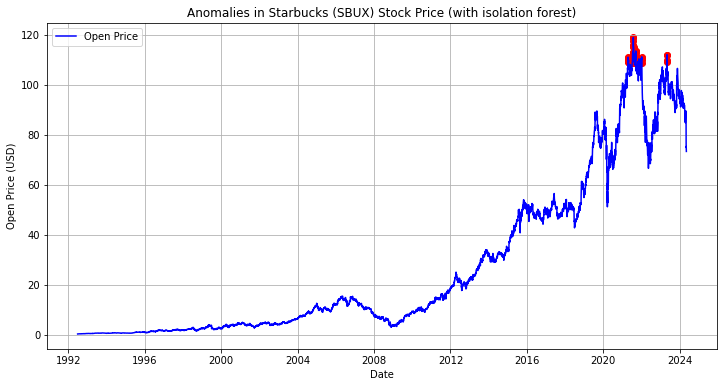

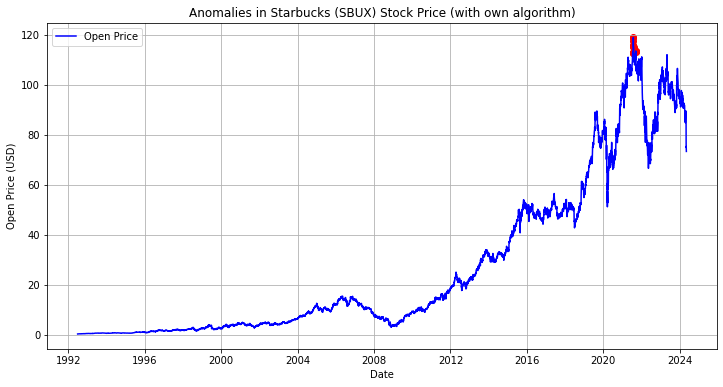

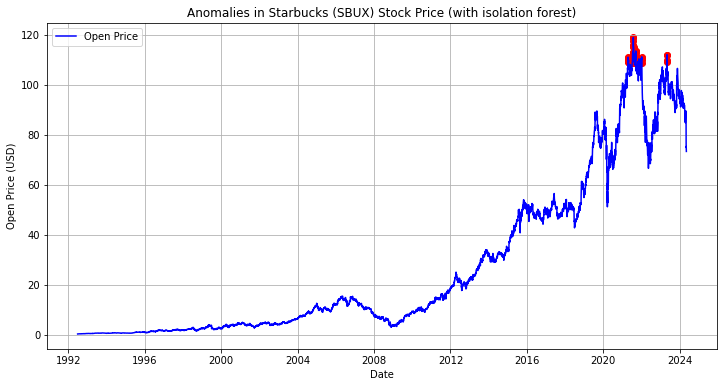

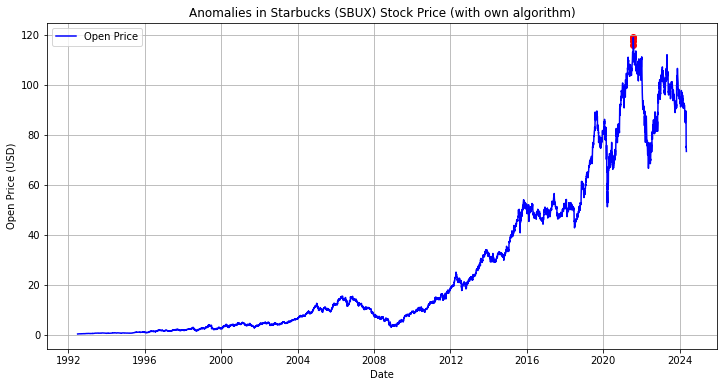

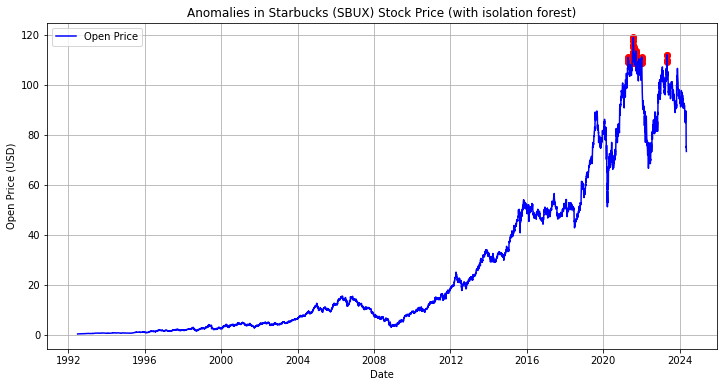

In [0]:
# 1. Collect and Analyze the data
log_dataset_pd, log_dataset_df = collect_stock_data('SBUX')

# 2. Preprocess and Visualize the data
log_preprocessed_df = preprocess_data(log_dataset_df, compute_correlation=True)
log_preprocessed_df_cache = log_preprocessed_df.cache()

# 3. Train isolation forest on train data 
log_dataset_broadcast = spark.sparkContext.broadcast(log_preprocessed_df_cache.collect())
log_dataset_val = np.array(log_dataset_broadcast.value)

trees_count_list = [50, 100, 150, 200]
subsample_count_list = [256, 512, 1024]

for tree_count in trees_count_list:
    for subsample_count in subsample_count_list:
        print("Trees Count: {}, Subsample Count: {}".format(tree_count, subsample_count))
        log_isolation_forest, log_anomaly_scores = train_isolation_forest(log_dataset_val, trees_count, subsample_count)

        # Computing anomaly labels to compare with sklearn's isolation forest 
        log_predicted_anomaly_label = compute_anomaly_label(log_anomaly_scores)

        # 4. Using sklearn's Isolation Forest model with the data
        model = IsolationForest(contamination=0.01)
        model.fit(log_dataset_val)
        log_isolation_forest_anomalies = model.predict(log_dataset_val)

        # 5. Comparing implemented algorithn and sklearn's algorithm
        compare_results(log_predicted_anomaly_label, log_isolation_forest_anomalies)
        visualize_data_and_anomalies(log_dataset_pd, np.array(log_predicted_anomaly_label), title='Anomalies in Starbucks (SBUX) Stock Price (with own algorithm)')
        visualize_data_and_anomalies(log_dataset_pd, log_isolation_forest_anomalies, title='Anomalies in Starbucks (SBUX) Stock Price (with isolation forest)')

Preprocessing data...


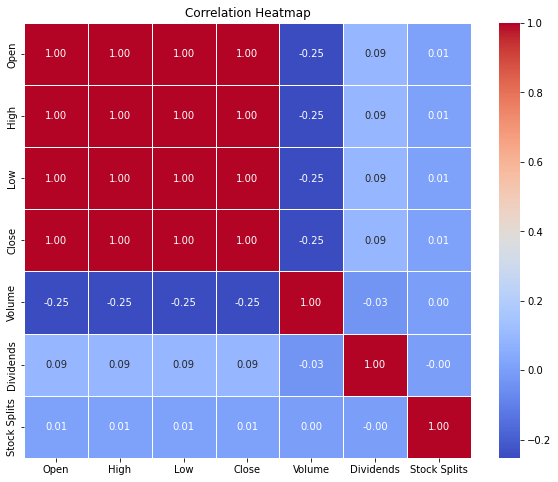

Trees Count: 50, Subsample Count: 256
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 10917
Count of incorrect anomaly scores: 23
Percentage of correct anomaly scores: 99.78976234003656
Percentage of incorrect anomaly scores: 0.21023765996343696
Trees Count: 50, Subsample Count: 512
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 10867
Count of incorrect anomaly scores: 73
Percentage of correct anomaly scores: 99.33272394881169
Percentage of incorrect anomaly scores: 0.6672760511882998
Trees Count: 50, Subsample Count: 1024
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct anomaly scores: 10848
Count of incorrect anomaly scores: 92
Percentage of correct anomaly scores: 99.15904936014626
Percentage of incorrect anomaly scores: 0.8409506398537478
Trees Count: 100, Subsample Count: 256
Constructing Isolation forest...
Isolation Forest constructed!
Count of correct 

<command-858231070792345>:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))


Isolation Forest constructed!
Count of correct anomaly scores: 10853
Count of incorrect anomaly scores: 87
Percentage of correct anomaly scores: 99.20475319926874
Percentage of incorrect anomaly scores: 0.7952468007312615


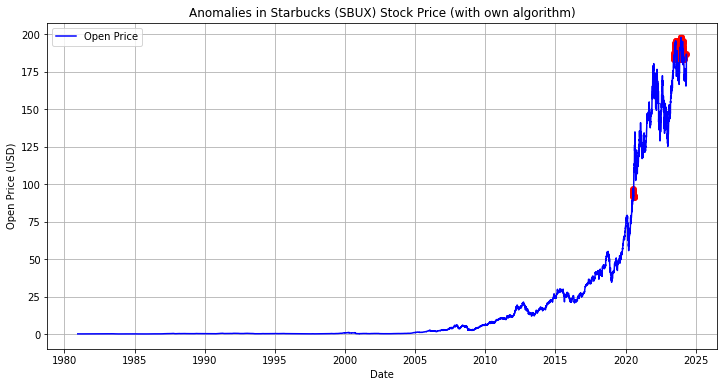

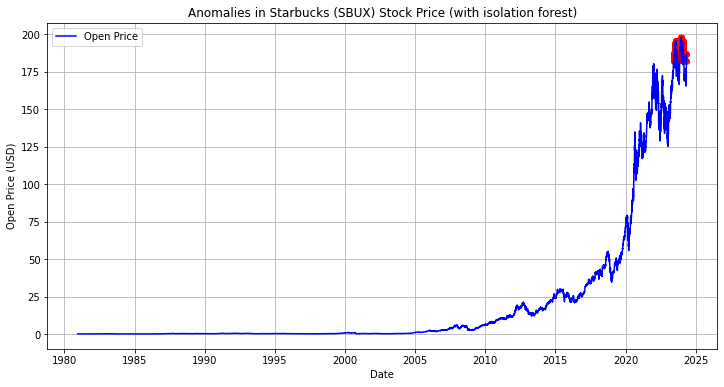

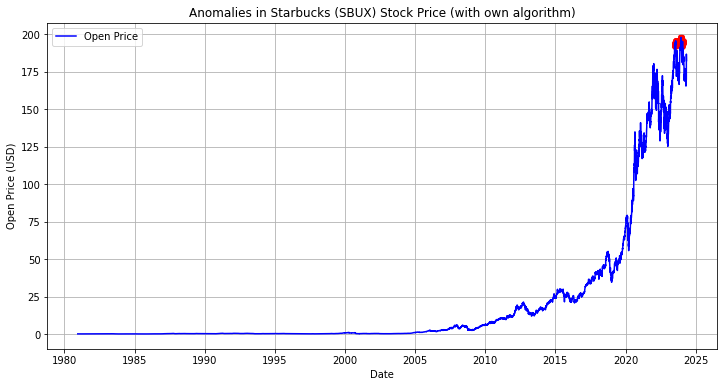

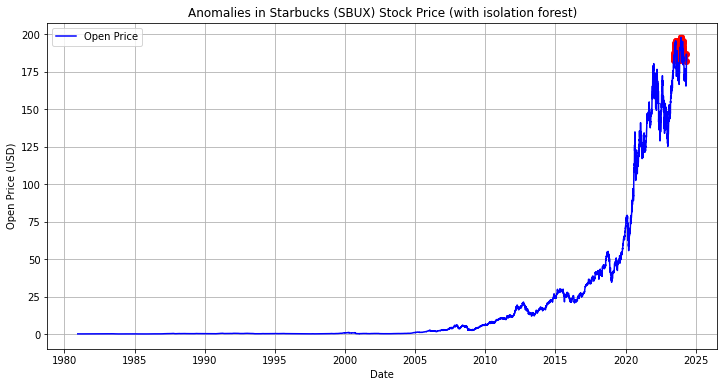

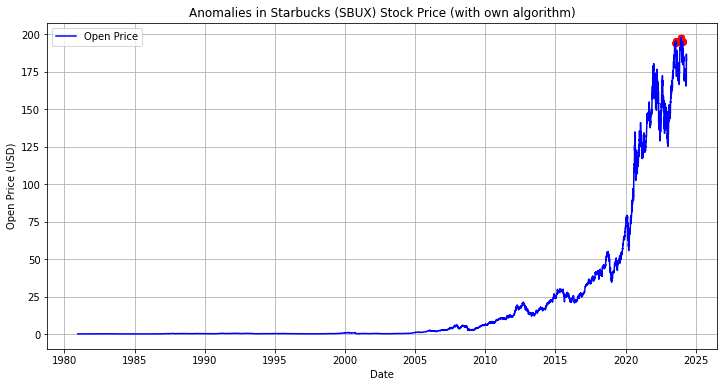

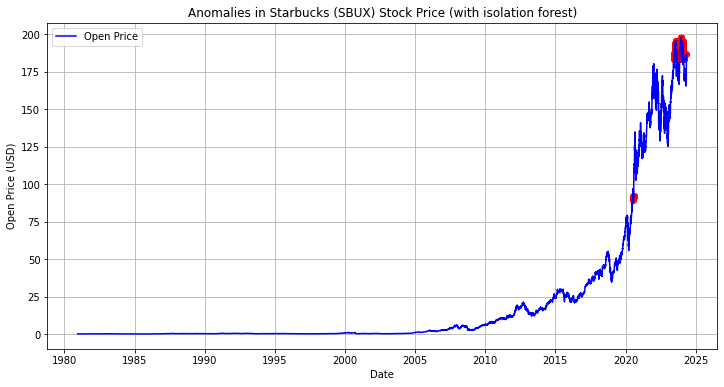

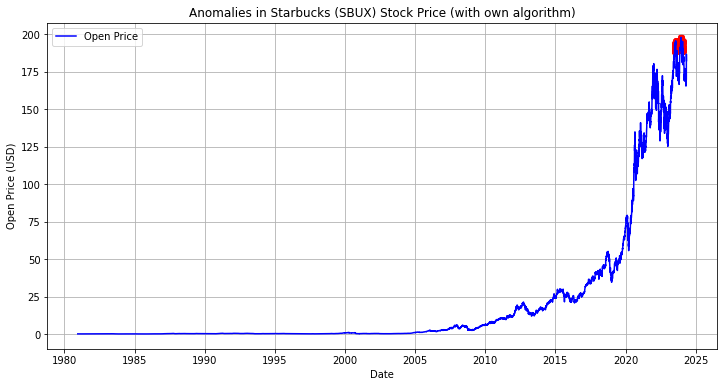

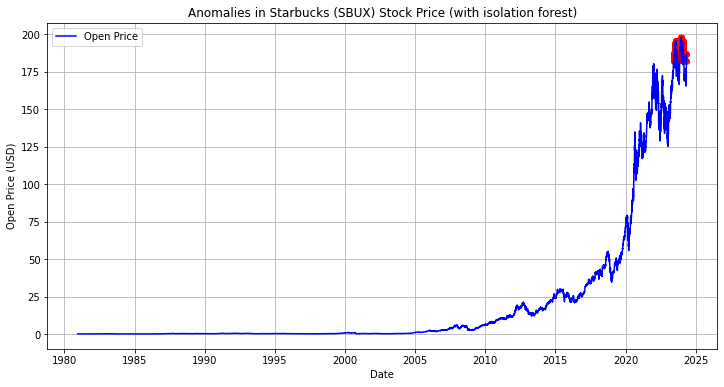

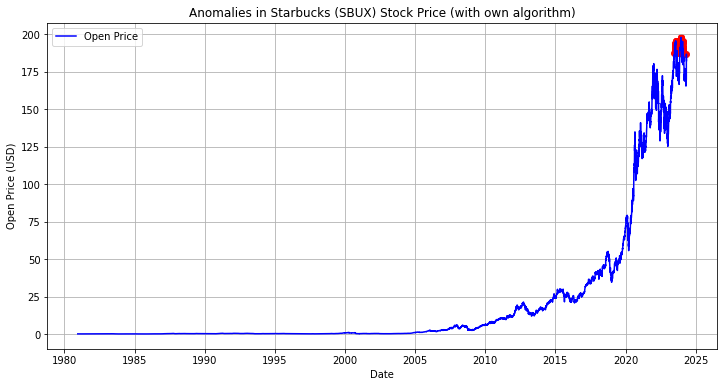

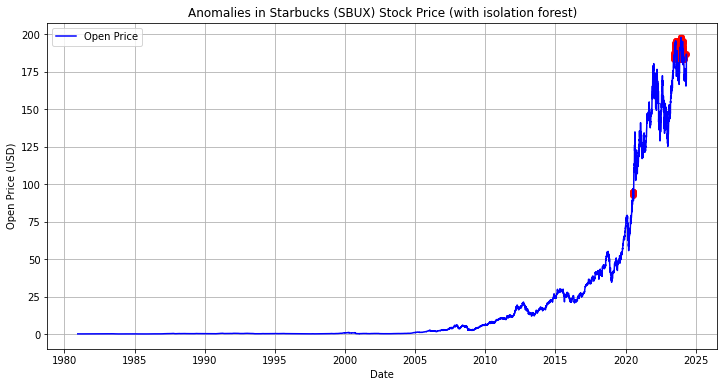

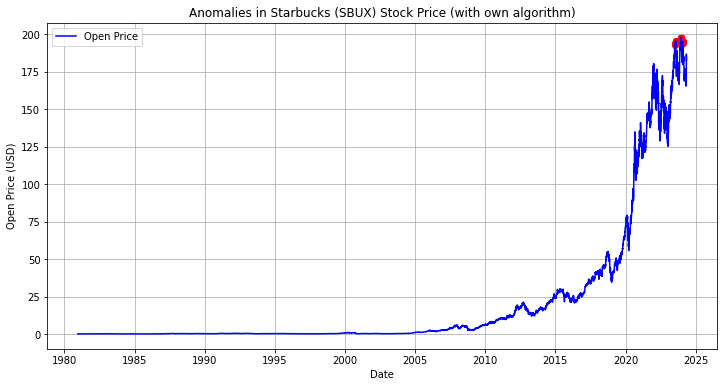

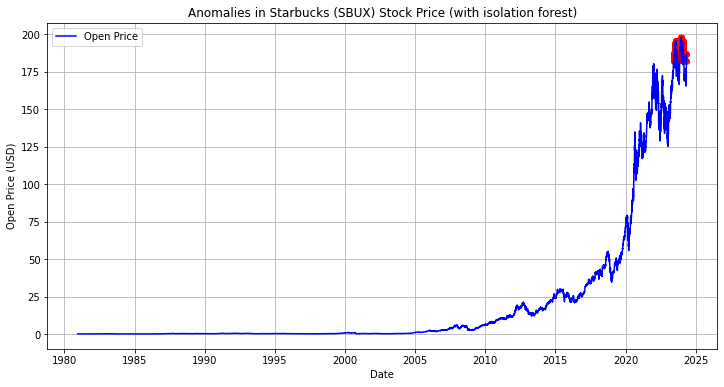

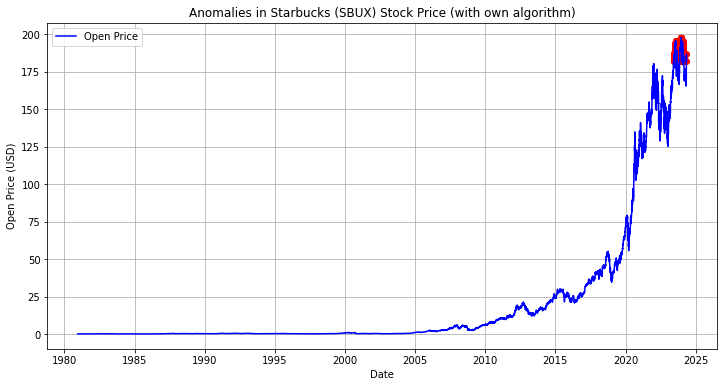

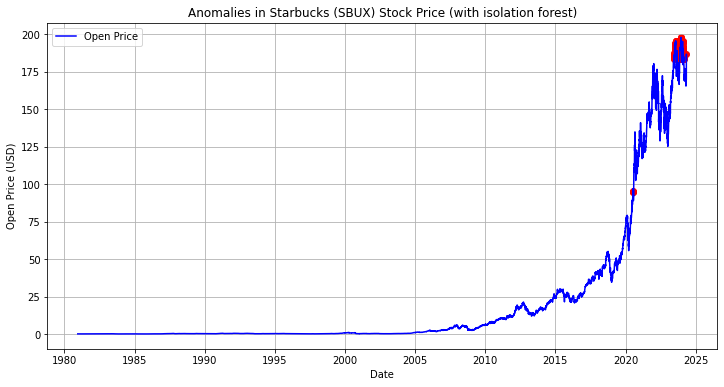

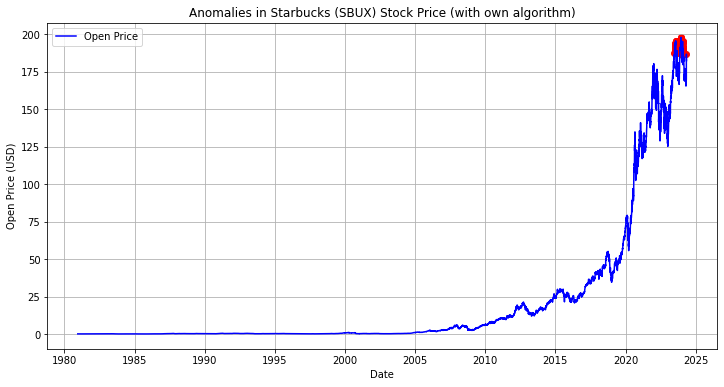

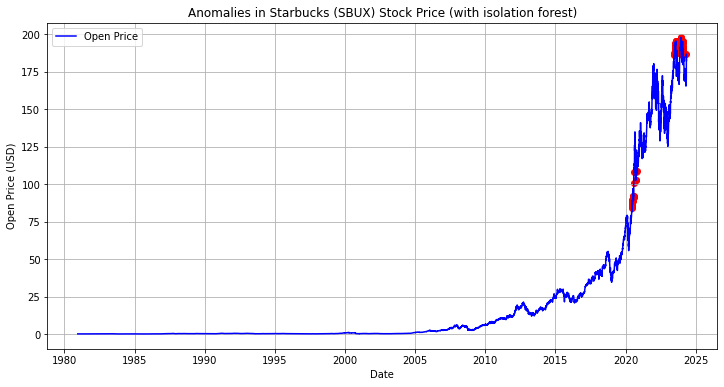

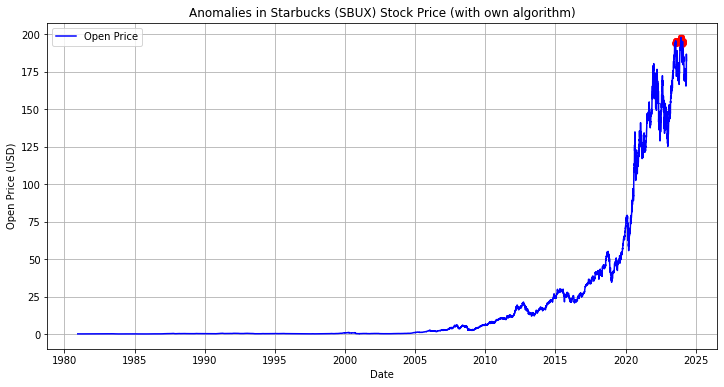

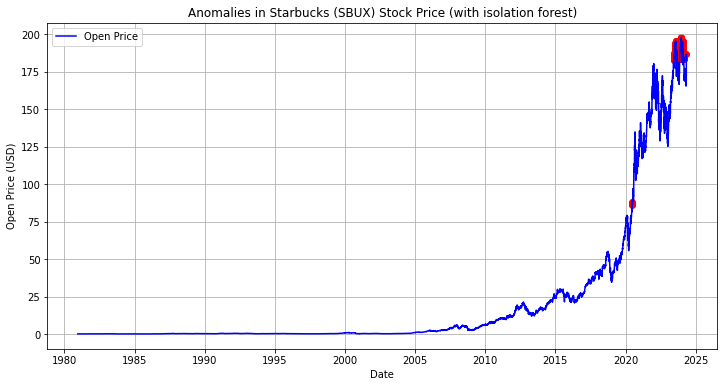

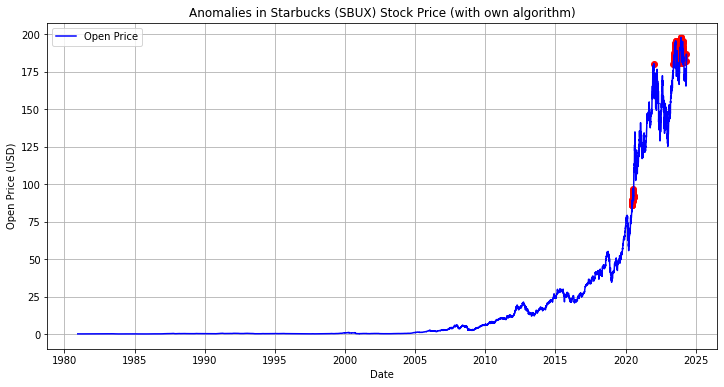

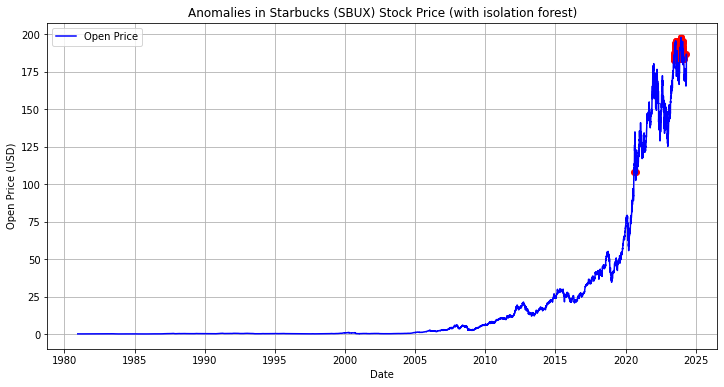

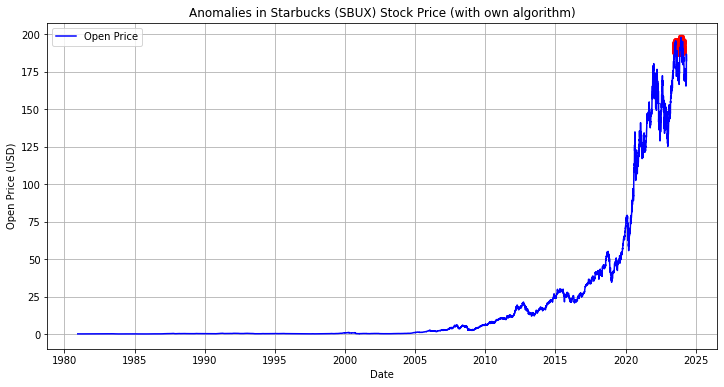

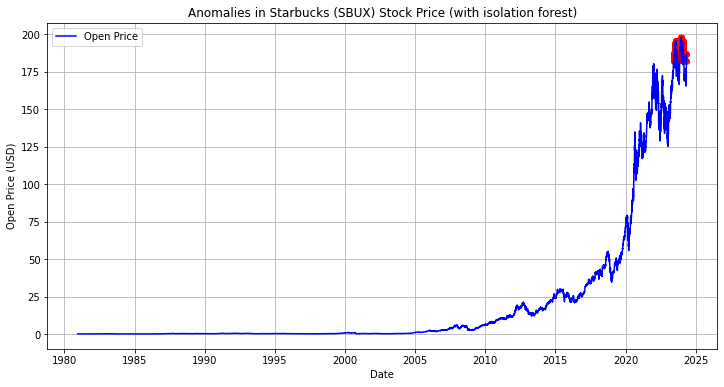

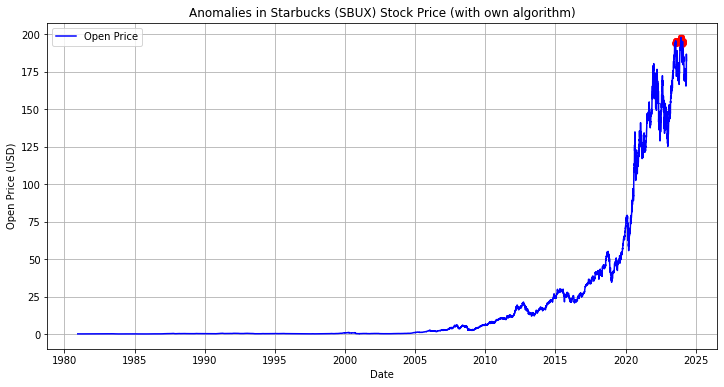

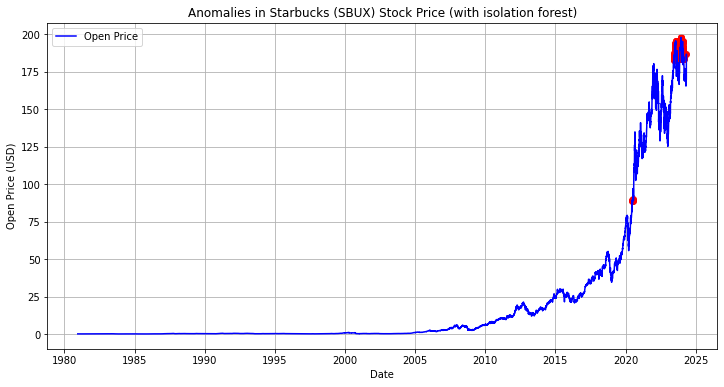

In [0]:
# 1. Collect and Analyze the data
log_dataset_pd, log_dataset_df = collect_stock_data('AAPL')

# 2. Preprocess and Visualize the data
log_preprocessed_df = preprocess_data(log_dataset_df, compute_correlation=True)
log_preprocessed_df_cache = log_preprocessed_df.cache()

# 3. Train isolation forest on train data 
log_dataset_broadcast = spark.sparkContext.broadcast(log_preprocessed_df_cache.collect())
log_dataset_val = np.array(log_dataset_broadcast.value)

trees_count_list = [50, 100, 150, 200]
subsample_count_list = [256, 512, 1024]

for tree_count in trees_count_list:
    for subsample_count in subsample_count_list:
        print("Trees Count: {}, Subsample Count: {}".format(tree_count, subsample_count))
        log_isolation_forest, log_anomaly_scores = train_isolation_forest(log_dataset_val, trees_count, subsample_count)

        # Computing anomaly labels to compare with sklearn's isolation forest 
        log_predicted_anomaly_label = compute_anomaly_label(log_anomaly_scores)

        # 4. Using sklearn's Isolation Forest model with the data
        model = IsolationForest(contamination=0.01)
        model.fit(log_dataset_val)
        log_isolation_forest_anomalies = model.predict(log_dataset_val)

        # 5. Comparing implemented algorithn and sklearn's algorithm
        compare_results(log_predicted_anomaly_label, log_isolation_forest_anomalies)
        visualize_data_and_anomalies(log_dataset_pd, np.array(log_predicted_anomaly_label), title='Anomalies in Starbucks (SBUX) Stock Price (with own algorithm)')
        visualize_data_and_anomalies(log_dataset_pd, log_isolation_forest_anomalies, title='Anomalies in Starbucks (SBUX) Stock Price (with isolation forest)')

In [0]:
spark.stop()